In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score


## Exploratory Data Analysis

In [2]:
df = pd.read_csv("allSeasons.csv")
df["FTR_numeric"] = df["FTR"].map({"H": 0, "D": 1, "A": 2})
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%y")
df.shape

(4440, 24)

Loads the dataset and maps the Full time result (`FTR`) to numeric values (Home win: 0, Draw: 1, Away win: 2). The dataset contains 24 different coloumns, with 4440 different matches. The dataset consist of 11 full seasons (2014/15 – 2024/25) and 260 matches from the 2025/26 season. Given its medium size (4440 matches and 24 features), Random Forest may be a suitable choice for classification.

In [3]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 4440 entries, 0 to 4439
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Unnamed: 0   4440 non-null   int64         
 1   Date         4440 non-null   datetime64[us]
 2   HomeTeam     4440 non-null   str           
 3   AwayTeam     4440 non-null   str           
 4   FTHG         4440 non-null   int64         
 5   FTAG         4440 non-null   int64         
 6   FTR          4440 non-null   str           
 7   HTHG         4440 non-null   int64         
 8   HTAG         4440 non-null   int64         
 9   HTR          4440 non-null   str           
 10  Referee      4440 non-null   str           
 11  HS           4440 non-null   int64         
 12  AS           4440 non-null   int64         
 13  HST          4440 non-null   int64         
 14  AST          4440 non-null   int64         
 15  HF           4440 non-null   int64         
 16  AF           4440

In [4]:
df.describe()

,Unnamed: 0,Date,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,FTR_numeric
count,4440.000000,4440,4440.000000,4440.000000,4440.000000,4440.000000,4440.000000,4440.000000,4440.000000,4440.000000,4440.000000,4440.000000,4440.000000,4440.000000,4440.000000,4440.000000,4440.000000,4440.000000,4440.000000
mean,185.986486,2020-05-12 11:30:29.189189,1.544595,1.259685,0.699324,0.555856,13.957207,11.454505,4.756532,3.980856,10.596171,10.962387,5.719820,4.704955,1.632432,1.837162,0.056757,0.068018,0.874324
min,0.000000,2014-08-16 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,92.000000,2017-05-06 00:00:00,1.000000,0.000000,0.000000,0.000000,10.000000,8.000000,3.000000,2.000000,8.000000,8.000000,3.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,184.500000,2020-07-03 00:00:00,1.000000,1.000000,0.000000,0.000000,13.000000,11.000000,4.000000,4.000000,10.000000,11.000000,5.000000,4.000000,1.000000,2.000000,0.000000,0.000000,1.000000
75%,279.000000,2023-04-08 00:00:00,2.000000,2.000000,1.000000,1.000000,17.000000,15.000000,6.000000,5.000000,13.000000,13.000000,8.000000,6.000000,2.000000,3.000000,0.000000,0.000000,2.000000
max,379.000000,2026-02-12 00:00:00,9.000000,9.000000,5.000000,5.000000,43.000000,37.000000,17.000000,15.000000,24.000000,26.000000,19.000000,19.000000,7.000000,9.000000,2.000000,2.000000,2.000000
std,108.901847,NaN,1.308400,1.196185,0.847667,0.770331,5.683907,4.994361,2.614609,2.330217,3.435268,3.555587,3.098934,2.755792,1.261141,1.308408,0.241875,0.257992,0.865065


In [5]:
df.tail()

,Unnamed: 0,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AST,HF,AF,HC,AC,HY,AY,HR,AR,FTR_numeric
4435,255,2026-02-11,Crystal Palace,Burnley,2,3,A,2,3,A,...,3,11,8,8,2,2,1,0,0,2
4436,256,2026-02-11,Man City,Fulham,3,0,H,3,0,H,...,3,8,10,4,4,3,1,0,0,0
4437,257,2026-02-11,Nott'm Forest,Wolves,0,0,D,0,0,D,...,3,12,13,8,2,0,2,0,0,1
4438,258,2026-02-11,Sunderland,Liverpool,0,1,A,0,0,D,...,3,8,10,3,11,1,0,0,0,2
4439,259,2026-02-12,Brentford,Arsenal,1,1,D,0,0,D,...,2,12,11,6,4,3,2,0,0,1


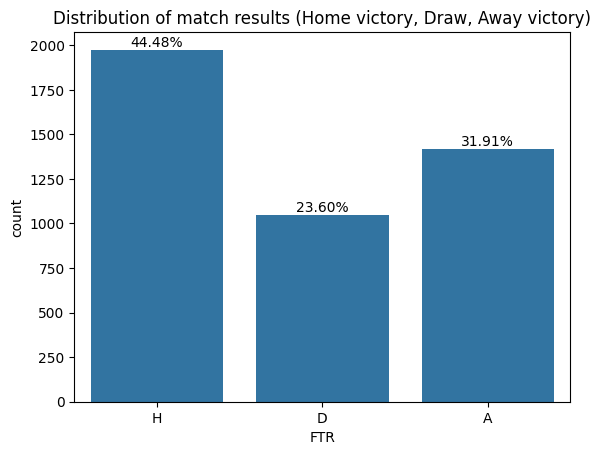

In [6]:
normalized_values = [f"{value*100:.2f}%" for value in df['FTR_numeric'].value_counts(normalize=True, sort=False)] 
ax = sns.countplot(x=df["FTR"])
ax.bar_label(container=ax.containers[0], labels=normalized_values)
plt.title("Distribution of match results (Home victory, Draw, Away victory)")
plt.show()


We see a fairly balanced distribution, but an advantage to teams playing at home. 

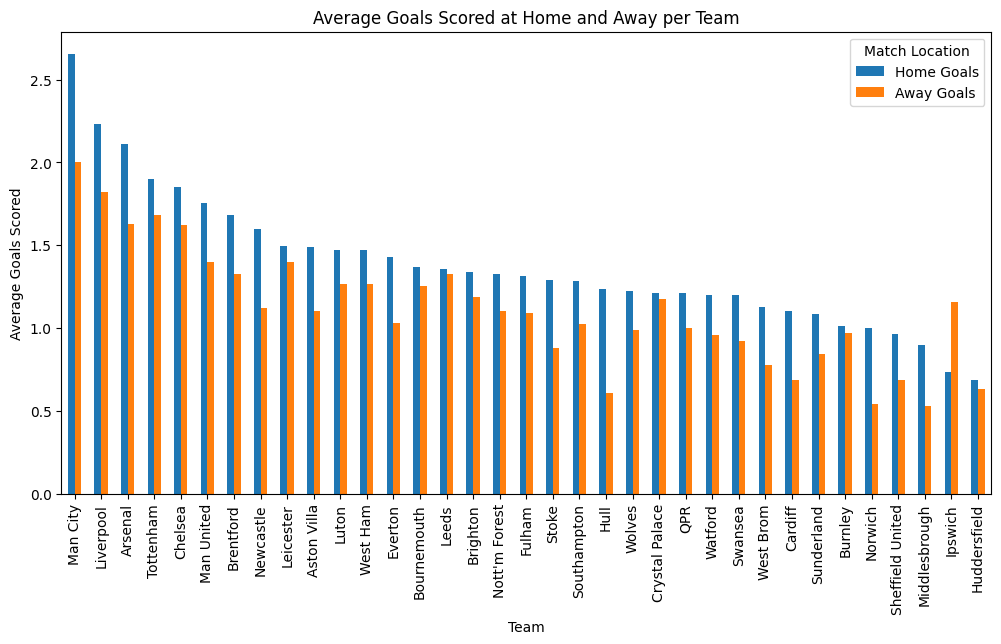

In [7]:
home_goals = df.groupby("HomeTeam")["FTHG"].mean()
away_goals = df.groupby("AwayTeam")["FTAG"].mean()

goals_df = pd.DataFrame({"Home Goals": home_goals, "Away Goals": away_goals})
goals_df = goals_df.sort_values("Home Goals", ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))
goals_df.plot(kind="bar", ax=ax)  

ax.set_ylabel("Average Goals Scored")
ax.set_xlabel("Team")
ax.set_title("Average Goals Scored at Home and Away per Team")
plt.xticks(rotation=90)  
plt.legend(title="Match Location")

plt.show()

This provides an overview of all the teams that have taken part in the Premier League from 14/15 to 24/25. It futher showcases how more effective teams playing at home are. 

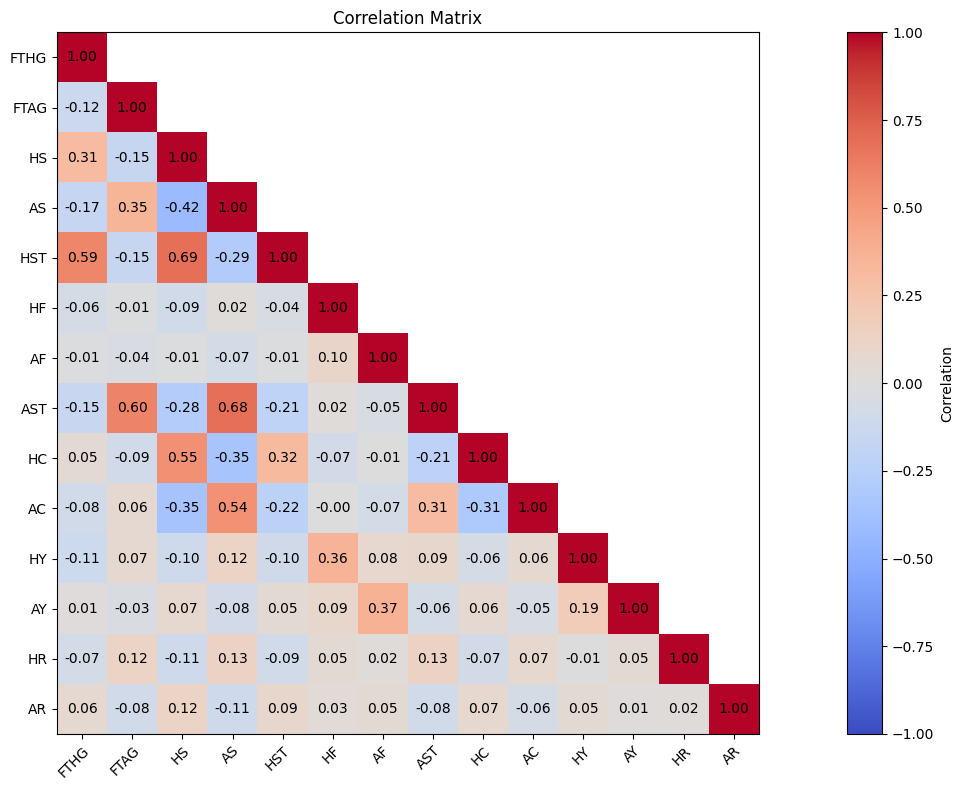

In [8]:
features_corr_matrix = ["FTHG", "FTAG", "HS", "AS", "HST", "HF", "AF", "AST", "HC", "AC", "HY", "AY", "HR", "AR"]

corr_matrix = df[features_corr_matrix].corr()
labels = corr_matrix.columns

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

fig, ax = plt.subplots(figsize=(18, 8))

masked_data = np.ma.array(corr_matrix.values, mask=mask)
im = ax.imshow(masked_data, cmap="coolwarm", vmin=-1, vmax=1)

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(labels)):
    for j in range(len(labels)):
        if not mask[i, j]:
            ax.text(j, i, f"{corr_matrix.values[i, j]:.2f}",
                    ha="center", va="center")

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Correlation")

ax.set_title("Correlation Matrix")
fig.tight_layout()
plt.show()



Home and Away corners, as well as variables related to fouls and cards, show little statistical impact on match outcomes. However, we observe that total shots (HS, AS) have a relatively weaker effect compared to shots on target (HST, AST), which appear to be more strongly correlated with goals scored (FTHG, FTAG).

### Elo-rating

This script implements an Elo rating system to evaluate the strength of football teams based on match results.
The Elo system originates from chess and dynamically adjusts team ratings after each match.

Key components:
- INITIAL_ELO: Default rating for new or promoted teams.
- K: Adjustment factor, controlling how much ratings change per match.
- C: Scaling factor to adjust the influence of match results on rating changes.

The system updates Elo ratings after each match based on the difference in team ratings and actual match outcomes.

In [9]:
# Initial values for Elo-rating
INITIAL_ELO = 1500  # Default rating for new teams
C = 1000  # Scaling factor for rating changes
K = 32  # Adjustment factor controlling rating updates

# Dictionary to store team ratings
team_ratings = {}

def get_team_rating(team):
    """
    Returns the Elo rating of a given team.
    If the team is not in the dictionary (e.g., a newly promoted team), it starts with INITIAL_ELO.
    """
    return team_ratings.get(team, INITIAL_ELO)

def update_elo_rating(home_team, away_team, home_score, away_score):
    """
    Updates the Elo ratings for both home and away teams based on match results.
    """
    global team_ratings
    
    R_home = get_team_rating(home_team) 
    R_away = get_team_rating(away_team)
    
    D_home = R_away - R_home
    D_away = R_home - R_away
    
    # Compute expected outcome probabilities (E)
    E_home = 1 / (1 + 10 ** (D_home / 400))
    E_away = 1 / (1 + 10 ** (D_away / 400))
    
    # Determine actual match outcome (S)
    if home_score > away_score:
        S_home, S_away = 1, 0  # Home team wins
    elif home_score < away_score:
        S_home, S_away = 0, 1  # Away team wins
    else:
        S_home, S_away = 0.5, 0.5  # Draw
    
    R_new_home = R_home + K * (S_home - E_home) - (K / (4 * C)) * D_home
    R_new_away = R_away + K * (S_away - E_away) - (K / (4 * C)) * D_away
    
    team_ratings[home_team] = R_new_home
    team_ratings[away_team] = R_new_away

df["home_elo"] = np.nan
df["away_elo"] = np.nan

for i, row in df.iterrows():
    home_team = row["HomeTeam"]
    away_team = row["AwayTeam"]
    home_score = row["FTHG"] 
    away_score = row["FTAG"] 
    
    df.at[i, "home_elo"] = get_team_rating(home_team)
    df.at[i, "away_elo"] = get_team_rating(away_team)
    
    update_elo_rating(home_team, away_team, home_score, away_score)

df.fillna(INITIAL_ELO, inplace=True)


,Unnamed: 0,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AF,HC,AC,HY,AY,HR,AR,FTR_numeric,home_elo,away_elo
0,0,2014-08-16,Arsenal,Crystal Palace,2,1,H,1,1,D,...,19,9,3,2,2,0,1,0,1500.000000,1500.000000
1,1,2014-08-16,Leicester,Everton,2,2,D,1,2,A,...,10,3,6,1,1,0,0,1,1500.000000,1500.000000
2,2,2014-08-16,Man United,Swansea,1,2,A,0,1,A,...,20,4,0,2,4,0,0,2,1500.000000,1500.000000
3,3,2014-08-16,QPR,Hull,0,1,A,0,0,D,...,10,8,9,1,2,0,0,2,1500.000000,1500.000000
4,4,2014-08-16,Stoke,Aston Villa,0,1,A,0,0,D,...,9,2,8,0,3,0,0,2,1500.000000,1500.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4435,255,2026-02-11,Crystal Palace,Burnley,2,3,A,2,3,A,...,8,8,2,2,1,0,0,2,1610.686125,1342.601759
4436,256,2026-02-11,Man City,Fulham,3,0,H,3,0,H,...,10,4,4,3,1,0,0,0,1875.572540,1594.462362
4437,257,2026-02-11,Nott'm Forest,Wolves,0,0,D,0,0,D,...,13,8,2,0,2,0,0,1,1557.479386,1385.990056
4438,258,2026-02-11,Sunderland,Liverpool,0,1,A,0,0,D,...,10,3,11,1,0,0,0,2,1496.302792,1777.369304


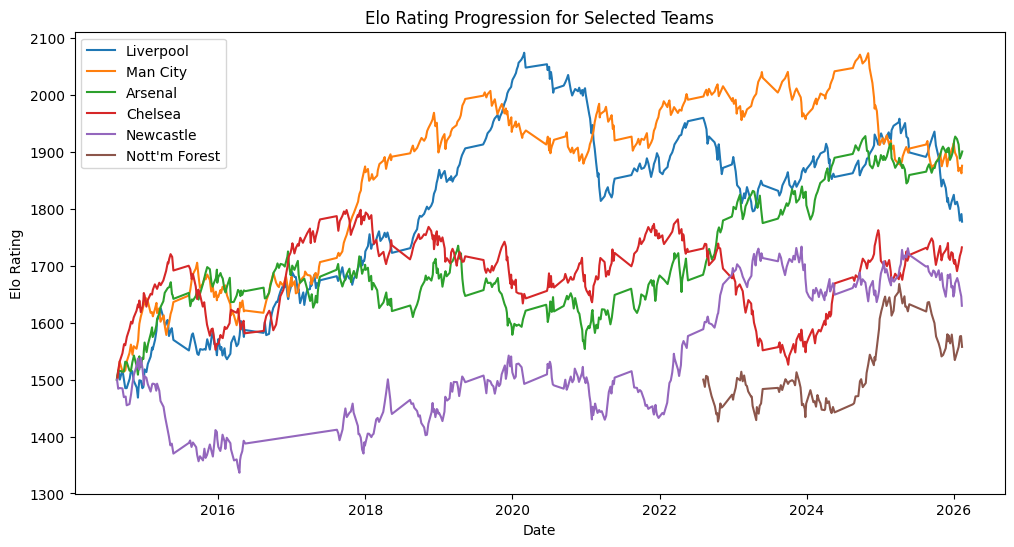

In [10]:
elo_history = []  # List to store Elo rating history for all teams


for i, row in df.iterrows():
    home_team = row["HomeTeam"]
    away_team = row["AwayTeam"]
    date = row["Date"]  
    
    home_elo = row["home_elo"] 
    away_elo = row["away_elo"] 
    
    # Store the Elo ratings for both teams on the given match date
    elo_history.append({"Date": date, "Team": home_team, "Elo": home_elo})
    elo_history.append({"Date": date, "Team": away_team, "Elo": away_elo})
    

elo_df = pd.DataFrame(elo_history)
elo_df.sort_values(by=["Team", "Date"], inplace=True)


selected_teams = ["Liverpool", "Man City", "Arsenal", "Chelsea", "Newcastle", "Nott'm Forest"]

plt.figure(figsize=(12, 6))

for team in selected_teams:
    team_data = elo_df[elo_df["Team"] == team]  
    plt.plot(team_data["Date"], team_data["Elo"], label=team)  

plt.xlabel("Date")
plt.ylabel("Elo Rating")
plt.title("Elo Rating Progression for Selected Teams")
plt.legend()
plt.show()


This plot illustrates the Elo rating progression of selected teams over time, highlighting how teams like Liverpool and Man City have consistently performed at a high level, maintaining strong ratings. Additionally, it showcases how promoted teams, such as Nottingham Forest, experience significant rating fluctuations, with a sharp increase in the recent year. The graph also reflects periods of dominance, decline, and resurgence for other teams like Arsenal, Chelsea, and Newcastle.

### Feature engeering

In [11]:
rolling_window = 5

# Calculate rolling average of goals scored in the last 5 matches
df["home_goals_last_5"] = df.groupby("HomeTeam")["FTHG"].transform(lambda x: x.rolling(rolling_window, min_periods=1).mean()) 
# min_periods sørger for at verdier for de kampene hvor det ikke har hvert 5 tidligere kamper
df["away_goals_last_5"] = df.groupby("AwayTeam")["FTAG"].transform(lambda x: x.rolling(rolling_window, min_periods=1).mean())

# Calculate rolling average of goals conceded in the last 5 matches
df["home_conceded_last_5"] = df.groupby("HomeTeam")["FTAG"].transform(lambda x: x.rolling(rolling_window, min_periods=1).mean())
df["away_conceded_last_5"] = df.groupby("AwayTeam")["FTHG"].transform(lambda x: x.rolling(rolling_window, min_periods=1).mean())

# Assign points based on match result:
df["home_points"] = df["FTR"].map({"H": 3, "D": 1, "A": 0})
df["away_points"] = df["FTR"].map({"H": 0, "D": 1, "A": 3})

# Compute rolling average of points earned in the last 5 matches
df["home_points_last_5"] = df.groupby("HomeTeam")["home_points"].transform(lambda x: x.rolling(rolling_window, min_periods=1).mean())
df["away_points_last_5"] = df.groupby("AwayTeam")["away_points"].transform(lambda x: x.rolling(rolling_window, min_periods=1).mean())


In [12]:
df1 = df.copy()
df2 = df.copy()

# Calculate rest days for home teams
df1 = df1.sort_values(by=["HomeTeam", "Date"]).reset_index(drop=True) 
df["home_rest_days"] = df1.groupby("HomeTeam")["Date"].diff().dt.days.fillna(7)  # Compute days since last match, fill NaN with 7 days 

# Calculate rest days for away teams
df2 = df2.sort_values(by=["AwayTeam", "Date"]).reset_index(drop=True)  
df["away_rest_days"] = df2.groupby("AwayTeam")["Date"].diff().dt.days.fillna(7)  # Compute days since last match, fill NaN with 7 days

In [13]:
selected_features = ['home_elo', 'away_elo', 'home_goals_last_5', 'away_goals_last_5', 'home_conceded_last_5',
       'away_conceded_last_5',
       'home_points_last_5', 'away_points_last_5', 'home_rest_days', 'away_rest_days']

## Training and testing

In [14]:
# Split the dataset into training and test sets
df_train = df.iloc[:-260] # Previous 11 seasons
df_test = df.iloc[-260:] # Current season

X_train = df_train[selected_features]
y_train = df_train['FTR_numeric']
X_test = df_test[selected_features]
y_test = df_test['FTR_numeric']

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")

print("Random Forest:")
print(classification_report(y_test, y_pred, target_names=["Home Win", "Draw", "Away Win"]))

Model accuracy: 0.63
Random Forest:
              precision    recall  f1-score   support

    Home Win       0.66      0.81      0.73       112
        Draw       0.50      0.26      0.34        69
    Away Win       0.64      0.70      0.67        79

    accuracy                           0.63       260
   macro avg       0.60      0.59      0.58       260
weighted avg       0.61      0.63      0.61       260



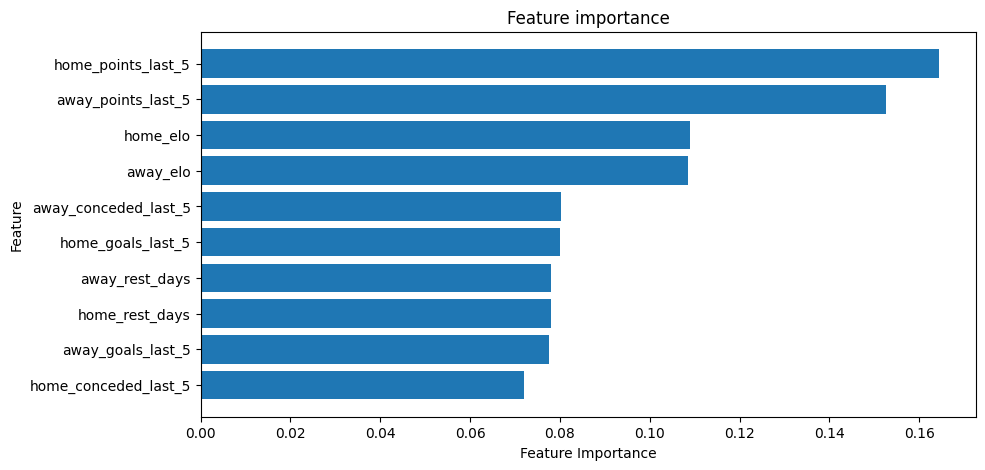

In [15]:
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,5))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature importance")
plt.gca().invert_yaxis()
plt.show()

In [16]:
# Find how often each outcome type occurs in the training data
baseline_probs = df_train['FTR_numeric'].value_counts(normalize=True)

# Calculate accuracy if we always predict the most probable outcome
baseline_accuracy = baseline_probs.max()
print(f"Baseline accuracy (most probable outcome): {baseline_accuracy:.2f}")


Baseline accuracy (most probable outcome): 0.45


### Model evaluation

Our Random Forest model achieved an accuracy of 63%, surpassing the baseline accuracy of 45%, which represents always predicting the most frequent outcome. This demonstrates that the model effectively leverages historical match data to improve predictive performance.
**Key Takeaways:**

**Classification Performance:**
- The model performs well in predicting home wins (66% precision, 81% recall) and away wins (64% precision, 70% recall).
- However, it struggles with draws (50% precision, 26% recall), likely due to the inherent difficulty in predicting evenly matched games.

**Feature Importance Analysis:**
The most influential features include recent team performance metrics, such as:
- Home/Away points from the last 5 matches
- Elo ratings (team strength)
- Goals scored/conceded in recent matches
- This displays how important the team's form is

Overall, the model provides useful insights and performs significantly better than random guessing or a naive baseline. However, additional feature engineering and hyperparameter tuning may be necessary to improve accuracy.

## Statistics

In [17]:
from scipy.stats import ttest_ind

home_win = df[df["FTR"] == "H"]["away_goals_last_5"]
home_loss = df[df["FTR"] == "A"]["away_goals_last_5"]

t_stat, p_value = ttest_ind(home_win, home_loss, equal_var=False)

print(f"T-statistic: {t_stat:.3f}, p-value: {p_value:.5f}")


T-statistic: -27.358, p-value: 0.00000


In [18]:
import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train)

model_sm = sm.MNLogit(y_train, X_train_sm) 
result = model_sm.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.740847
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:            FTR_numeric   No. Observations:                 4180
Model:                        MNLogit   Df Residuals:                     4158
Method:                           MLE   Df Model:                           20
Date:                Sat, 21 Feb 2026   Pseudo R-squ.:                  0.3042
Time:                        15:02:34   Log-Likelihood:                -3096.7
converged:                       True   LL-Null:                       -4450.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
       FTR_numeric=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    4.0711      0.886      4.596      0.000       2.335       5.807

## Hyperparameter tuning

In [19]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 5, 10, 20],
    "max_features": ["sqrt", "log2", 0.5],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False],
    "class_weight": [None, "balanced"]
}

rf = RandomForestClassifier(random_state=42)

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)


Fitting 3 folds for each of 864 candidates, totalling 2592 fits
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'bootstrap': [True, False], 'class_weight': [None, 'balanced'], 'max_depth': [None, 5, ...], 'max_features': ['sqrt', 'log2', ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for eac

In [20]:
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["Home Win", "Draw", "Away Win"]))

Best params: {'bootstrap': True, 'class_weight': None, 'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best CV score: 0.6681834395726668
Test accuracy: 0.6384615384615384
              precision    recall  f1-score   support

    Home Win       0.69      0.80      0.74       112
        Draw       0.47      0.22      0.30        69
    Away Win       0.62      0.77      0.69        79

    accuracy                           0.64       260
   macro avg       0.59      0.60      0.58       260
weighted avg       0.61      0.64      0.61       260



Hyperparameter tuning provided only a small and statistically insignificant improvement, suggesting that the model is close to its performance ceiling given the current feature set.